In [169]:
# Data handling 
import numpy as np
import pandas as pd

# Viz
import arviz as az
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel
import daft

# modeling
import pymc3 as pm
from scipy import stats
from theano import shared

### Spurious association

In [5]:
df = pd.read_csv("../Data/WaffleDivorce.csv", sep=";")

In [6]:
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [7]:
# Standardize variables

divorce_std = (df["Divorce"] - df["Divorce"].mean())/df["Divorce"].std()
marriage_std = (df["Marriage"] - df["Marriage"].mean())/df["Marriage"].std()
age_std = (df["MedianAgeMarriage"] - df["MedianAgeMarriage"].mean())/df["MedianAgeMarriage"].std()

In [8]:
# Develop linear age - divorce rate model
with pm.Model() as AgeDivmodel:
    A = pm.Data("A",
                age_std
               )
    
    # Priors
    alpha = pm.Normal("alpha",
                      mu=0,
                      sd=0.2
                     )
    beta_age = pm.Normal("beta_age",
                         mu=0,
                         sd=0.5
                        )
    div_mu = pm.Deterministic("div_mu",
                              var=alpha + beta_age*A
                             )
    div_sd = pm.Exponential("div_sd",
                            lam=1  # Here all the measurements are in standar deviation units
                           )
    
    # Likelihood
    
    div = pm.Normal("div",
                    mu=div_mu,
                    sd=div_sd,
                    observed=divorce_std
                   )

In [9]:
with AgeDivmodel:
    prior_samples = pm.sample_prior_predictive(1000)
    age_div_trace = pm.sample(1000,
                              return_inferencedata=True
                             )
    post_samples = pm.sample_posterior_predictive(age_div_trace,
                                                  1000
                                                 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [div_sd, beta_age, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [12]:
prior_samples.keys()

dict_keys(['div_sd_log__', 'div_mu', 'div', 'alpha', 'div_sd', 'beta_age'])

Text(0, 0.5, 'Divorce rate (std)')

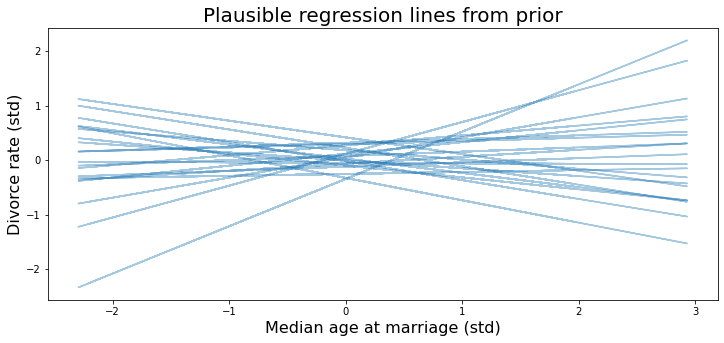

In [21]:
# Plot prior distribution

_, ax = plt.subplots(figsize=(12, 5))

for i in range(20):
    idx = np.random.randint(0, 1000, dtype=int)
    ax.plot(age_std,
            prior_samples["alpha"][idx] + prior_samples["beta_age"][idx]*age_std,
            "C0-",
            alpha=0.4
           )
    
ax.set_title("Plausible regression lines from prior", size=20)
ax.set_xlabel("Median age at marriage (std)", fontdict={"fontsize":16})
ax.set_ylabel("Divorce rate (std)", fontdict={"fontsize":16})
             

#### Investigate posterior distribution

In [22]:
az.summary(age_div_trace, var_names=["~div_mu"], kind="stats", round_to=3)

,mean,sd,hdi_3%,hdi_97%
alpha,0.003,0.103,-0.184,0.193
beta_age,-0.566,0.119,-0.794,-0.357
div_sd,0.824,0.088,0.661,0.983


In [42]:
alpha_post = age_div_trace.posterior.stack(draws=("chain", "draw")).data_vars["alpha"]
beta_age_post = age_div_trace.posterior.stack(draws=("chain", "draw")).data_vars["beta_age"]
div_sd_post = age_div_trace.posterior.stack(draws=("chain", "draw")).data_vars["div_sd"]
div_mu_post = age_div_trace.posterior.stack(draws=("chain", "draw")).data_vars["div_mu"]

In [75]:
div_mu_post.T.shape

(4000, 50)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:>

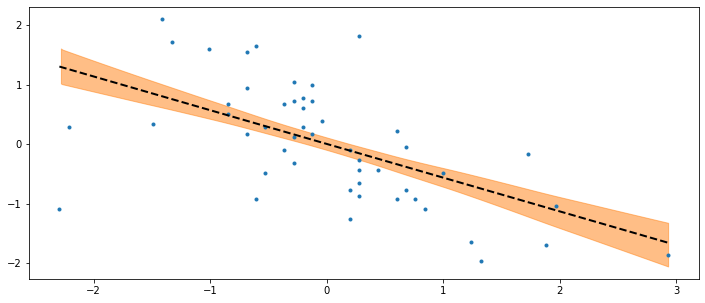

In [86]:
_, ax = plt.subplots(figsize=(12, 5))

ax.plot(age_std,
        divorce_std,
        "C0.",
        label="Observed divorce rate"
       )
ax.plot(np.sort(age_std),
        alpha_post.mean().values + beta_age_post.mean().values*np.sort(age_std),
        "k--",
        linewidth=2,
        label="Mean expected rate"
       )
az.plot_hdi(
    age_std,
    div_mu_post.T,
    hdi_prob=0.69,
    ax=ax
)

#### Multiple regression

In [87]:
with pm.Model() as multi_model:
    # Priors
    alpha = pm.Normal("alpha",
                      mu=0,
                      sd=0.2
                     )
    beta_m = pm.Normal("beta_m",
                       mu=0,
                       sd=0.5
                      )
    beta_a = pm.Normal("beta_a",
                       mu=0,
                       sd=0.5
                      )
    div_mu = pm.Deterministic("div_mu",
                              var = alpha + beta_m*marriage_std + beta_a*age_std
                             )
    div_sd = pm.Exponential("div_sd",
                            1/0.3
                           )
    # Likelihood
    div = pm.Normal("div",
                    mu=div_mu,
                    sd=div_sd,
                    observed=divorce_std
                   )

In [88]:
with multi_model:
    multi_trace = pm.sample(1000,
                            return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [div_sd, beta_a, beta_m, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [90]:
az.summary(multi_trace, var_names=["~div_mu"], kind="stats", round_to=2)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
alpha,0.00,0.10,-0.19,0.18
beta_m,-0.06,0.16,-0.34,0.25
beta_a,-0.61,0.16,-0.91,-0.32
div_sd,0.81,0.08,0.65,0.95


In [144]:
with multi_model:
    div_samples = pm.sample_posterior_predictive(multi_trace,
                                                 samples=1000,
                                                 var_names=["div_mu", "div"],
                                                 )

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [145]:
div_samples["div"].shape

(1000, 50)

In [146]:
div_mu_samples_mean = div_samples["div_mu"].mean(0)
div_samples_mean = div_samples["div"].mean(0)

In [149]:
div_mu_samples_sigma = az.hdi(div_samples["div_mu"], hdi_prob=0.89)
div_samples_sigma = az.hdi(div_samples["div"], hdi_prob=0.89)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


In [152]:
div_mu_samples_mean.shape

(50,)

In [154]:
div_mu_samples_sigma.T.shape

(2, 50)

<ErrorbarContainer object of 3 artists>

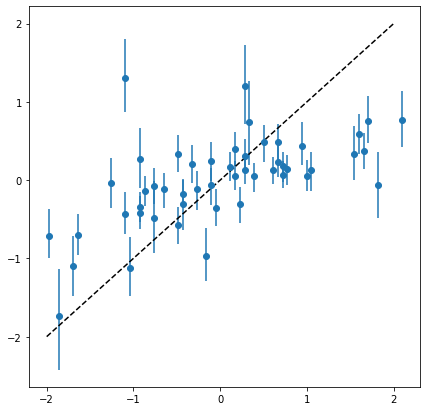

In [151]:
_, ax = plt.subplots(figsize=(7, 7))

ax.plot([-2, 2], [-2, 2], "k--")

ax.errorbar(divorce_std,
            div_mu_samples_mean,
            yerr = np.abs(div_mu_samples_mean - div_mu_samples_sigma.T),
            fmt="o"
           )

#### Counterfactual plots

In [177]:
# Extended model with multiple regression models

with pm.Model() as extended_model:
    # Shared data
    A = shared(value=age_std.values,
               name="A"
               )
    M = shared(name="M",
               value=marriage_std.values
               )
    
    # A -> M
    
    # Priors
    alphaA = pm.Normal("alphaA",
                       mu=0,
                       sd=0.2
                      )
    betaAM = pm.Normal("betaAM",
                       mu=0,
                       sd=0.5
                      )
    mar_mu = pm.Deterministic("mar_mu",
                              var=alphaA + betaAM*A
                             )
    mar_sd = pm.Exponential("mar_sd",
                            lam=1/0.2
                           )
    # Likelihood
    mar = pm.Normal("mar",
                    mu=mar_mu,
                    sd=mar_sd,
                    observed=M)   
    
    # A -> D <- M
    
    # Priors
    alpha = pm.Normal("alpha",
                        mu=0,
                        sd=0.2
                       )
    betaA = pm.Normal("betaA",
                      mu=0,
                      sd=0.5
                     )
    betaM = pm.Normal("betaM",
                      mu=0,
                      sd=0.5
                     )
    div_mu = pm.Deterministic("div_mu",
                              var=alpha + betaA*A + betaM*M
                             )
    div_sd = pm.Exponential("div_sd",
                            lam=1/0.2)
    # Likelihood
    div = pm.Normal("div",
                    mu=div_mu,
                    sd=div_sd,
                    observed=divorce_std
                   )               

In [178]:
with extended_model:
    extended_trace = pm.sample(1000,
                               return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [div_sd, betaM, betaA, alpha, mar_sd, betaAM, alphaA]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [174]:
az.summary(extended_trace, var_names=["alpha", "betaA", "betaM", "div_sd",
                                      "alphaA", "betaAM", "mar_sd"], kind="stats", round_to=2)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
alpha,0.00,0.10,-0.18,0.18
betaA,-0.61,0.15,-0.90,-0.32
betaM,-0.06,0.15,-0.34,0.24
div_sd,0.80,0.08,0.66,0.95
alphaA,-0.00,0.09,-0.17,0.16
betaAM,-0.69,0.10,-0.86,-0.50
mar_sd,0.69,0.07,0.57,0.83


In [175]:
# Test values for the marriage age

A_seq = np.linspace(-2, 2, 30)

In [185]:
# Simulate values for the new marriage ages
# With pymc3 we need to run this sequentially

with extended_model:
    A.set_value(A_seq)
    sim_M_data = pm.sample_posterior_predictive(extended_trace,
                                                var_names=["mar"],
                                                samples=1000)["mar"]
    M.set_value(sim_M_data.mean(0))
    sim_data = pm.sample_posterior_predictive(extended_trace,
                                              var_names=["mar_mu", "mar", "div_mu", "div"],
                                              samples=1000)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'Counterfactual marriage rate (std)')

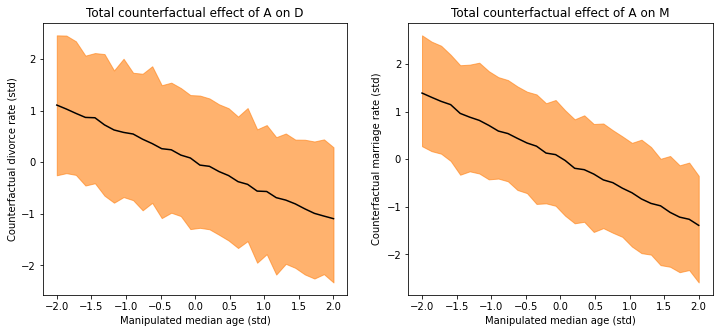

In [198]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(A_seq,
             sim_data["div"].mean(0),
             "k-",
            )
axes[0].fill_between(A_seq,
                     az.hdi(sim_data["div"], hdi_prob=0.89)[:, 0],
                     az.hdi(sim_data["div"], hdi_prob=0.89)[:, 1],
                     alpha=0.6,
                     color="C1"
                    )
axes[0].set_title("Total counterfactual effect of A on D")
axes[0].set_xlabel("Manipulated median age (std)")
axes[0].set_ylabel("Counterfactual divorce rate (std)")

axes[1].plot(A_seq,
             sim_data["mar"].mean(0),
             "k-",
            )
axes[1].fill_between(A_seq,
                     az.hdi(sim_data["mar"], hdi_prob=0.89)[:, 0],
                     az.hdi(sim_data["mar"], hdi_prob=0.89)[:, 1],
                     alpha=0.6,
                     color="C1"
                    )
axes[1].set_title("Total counterfactual effect of A on M")
axes[1].set_xlabel("Manipulated median age (std)")
axes[1].set_ylabel("Counterfactual marriage rate (std)")

### Masked relationships

In [201]:
df = pd.read_csv("../Data/milk.csv", sep=";")

In [202]:
df.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [203]:
# Function to standardize variables

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean())/series.std()

In [206]:
df = df.dropna()

energy_std = standardize(df["kcal.per.g"])
neo_std = standardize(df["neocortex.perc"])
mass_std = standardize(np.log(df["mass"]))

#### Energy vs. neocortex

In [247]:
with pm.Model() as m55:
    # Data
    N = pm.Data("N",
                neo_std
               )
    
    # Priors
    alpha = pm.Normal("alpha",
                      mu=0,
                      sd=0.2
                     )
    betaN = pm.Normal("betaN",
                      mu=0,
                      sd=0.5
                     )
    en_mu = pm.Deterministic("en_mu",
                             var=alpha + betaN*N
                            )
    en_sd = pm.Exponential("en_sd",
                           lam=1
                          )
    
    # Likelihood
    en = pm.Normal("en",
                   mu=en_mu,
                   sd=en_sd,
                   observed=energy_std
                  )

In [248]:
# Fit for posterior and sample for predictions

with m55:
    m55_trace = pm.sample(1000,
                          return_inferencedata=True
                         )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [en_sd, betaN, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [225]:
# Sample prior distribution

# It's useful to use a new sets of values to sample the data that are ordered for plotting reasons
neo_seq = np.linspace(-2, 2, 30)

with m55:
    pm.set_data({"N": neo_seq})
    prior_samples = pm.sample_prior_predictive(samples=40)

(-2.0, 2.0)

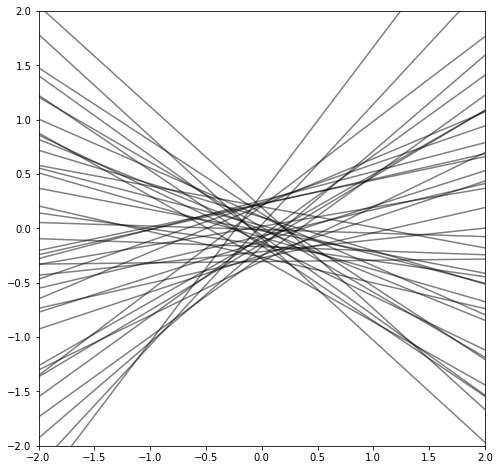

In [226]:
_, ax = plt.subplots(figsize=(8, 8))

for i in range(len(prior_samples["en"])):
    ax.plot(neo_seq,
            prior_samples["alpha"][i] + prior_samples["betaN"][i]*neo_seq,
            "k-",
            alpha=0.5
           )
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

In [236]:
with m55:
    post_samples = pm.sample_posterior_predictive(m55_trace,
                                                  samples=1000,
                                                  var_names=["en", "en_mu", "alpha", "betaN"]
                                                 )

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [229]:
az.summary(m55_trace, var_names=["~en_mu"], kind="stats", round_to=2)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
alpha,-0.00,0.16,-0.31,0.29
betaN,0.12,0.23,-0.30,0.55
en_sd,1.03,0.19,0.73,1.39


C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


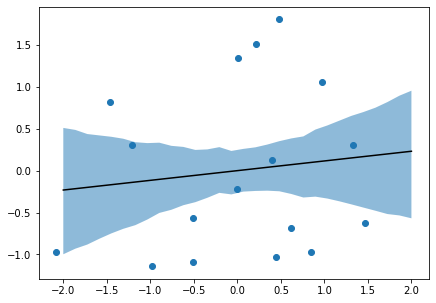

In [239]:
_, ax = plt.subplots(figsize=(7, 5))

ax.plot(neo_std,
        energy_std,
        "C0o",
       )
ax.plot(neo_seq,
        post_samples["alpha"].mean() + post_samples["betaN"].mean()*neo_seq,
        "k-"
       )
ax.fill_between(neo_seq,
                az.hdi(post_samples["en_mu"], hdi_prob=0.89)[:, 0],
                az.hdi(post_samples["en_mu"], hdi_prob=0.89)[:, 1],
                alpha=0.5
               )

#### Energy vs. mass

In [241]:
with pm.Model() as m56:
    # Data
    M = pm.Data("M",
                mass_std
               )
    
    # Priors
    alpha = pm.Normal("alpha",
                      mu=0,
                      sd=0.2
                     )
    betaM = pm.Normal("betaM",
                      mu=0, 
                      sd=0.5
                     )
    en_mu = pm.Deterministic("en_mu",
                             var=alpha + betaM*M
                            )
    en_sd = pm.Exponential("en_sd",
                           lam=1
                          )
    
    #Likelihood
    en = pm.Normal("en",
                   mu=en_mu,
                   sd=en_sd,
                   observed=energy_std
                  )

In [242]:
# Fit posterior
with m56:
    m56_trace = pm.sample(1000,
                          return_inferencedata=True
                         )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [en_sd, betaM, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [243]:
az.summary(m56_trace, var_names=["~en_mu"], kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,-0.00,0.15,-0.29,0.28
betaM,-0.28,0.22,-0.71,0.13
en_sd,0.99,0.18,0.69,1.34


#### Energy vs. neocortex & mass

In [244]:
with pm.Model() as m57:
    # Data
    N = pm.Data("N",
                neo_std
               )
    M = pm.Data("M",
                mass_std
               )
    
    # Priors
    alpha = pm.Normal("alpha",
                      mu=0,
                      sd=0.2
                     )
    betaN = pm.Normal("betaN",
                      mu=0,
                      sd=0.5
                     )
    betaM = pm.Normal("betaM",
                      mu=0,
                      sd=0.5
                     )
    en_mu = pm.Deterministic("en_mu",
                             var=alpha + betaN*N + betaM*M
                            )
    en_sd = pm.Exponential("en_sd",
                           lam=1
                          )
    # Likelihood
    en = pm.Normal("en",
                   mu=en_mu,
                   sd=en_sd,
                   observed=energy_std
                  )

In [245]:
# Fit posterior
with m57:
    m57_trace = pm.sample(1000,
                          return_inferencedata=True
                         )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [en_sd, betaM, betaN, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


#### Compare models

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

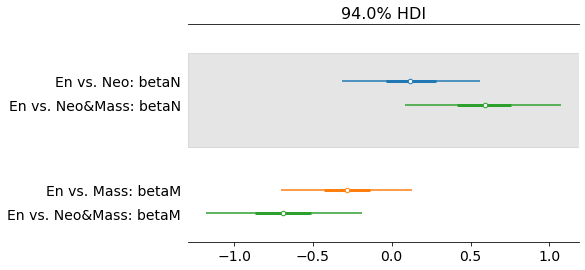

In [252]:
_, ax = plt.subplots(figsize=(7, 4))

az.plot_forest(data=[m55_trace, m56_trace, m57_trace],
               model_names=["En vs. Neo", "En vs. Mass", "En vs. Neo&Mass"],
               var_names=["betaN", "betaM"],
               combined=True,
               ax=ax
              )

### Categorical variables

In [253]:
df = pd.read_csv("../Data/Howell1.csv", sep=";")

In [261]:
height_obs = df["height"]
sex_ids = pd.Categorical(df["male"]).codes
num_sex = len(np.unique(sex_ids))

In [267]:
# Define gender model

with pm.Model() as m58:
    # Priors
    h_mu = pm.Normal("h_mu",
                     mu=178,
                     sd=20,
                     shape=num_sex
                    )
    h_sd = pm.Uniform("h_sd",
                      lower=0,
                      upper=50
                     )
    # Likelihood
    h = pm.Normal("h",
                  mu=h_mu[sex_ids],
                  sd=h_sd,
                  observed=height_obs
                 )
    
    diff_h = pm.Deterministic("diff_h",
                              var = h_mu[0] - h_mu[1]
                             )

In [268]:
# Fit posterior

with m58:
    m58_trace = pm.sample(1000,
                          return_inferencedata=True
                         )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h_sd, h_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [270]:
az.summary(m58_trace, var_names=["h_mu", "h_sd", "diff_h"], kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
h_mu[0],134.88,1.61,131.97,137.96
h_mu[1],142.59,1.78,139.19,145.85
h_sd,27.42,0.83,25.85,28.91
diff_h,-7.71,2.37,-12.20,-3.35
